# FEATURIZATION PROJECT




Importing the neccessary libraries

In [9]:
# Data Manipulation
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np

# Ploting Libraries
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformation and Feature Generation
from scipy.stats import zscore
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Model Training Classes
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Model Metrics functions
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

# Ignore warnings in the notebook
from warnings import filterwarnings
filterwarnings("ignore")

from scipy.stats import skew, ttest_ind, mannwhitneyu, chisquare, shapiro

target="strength"

# Analyzing Attributes: 

In [10]:
# Reading the data as dataframe and print the first five rows
df = pd.read_csv('concrete.csv')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [11]:
df.shape

(1030, 9)

In [12]:
# Get info of the dataframe columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [13]:
# Checking missing values in dataframe
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

# Correlation Analysis

We will explore if any strong linear correlations are present in the columns. Only the correlation values of the cells higher that 0.3 and lower than -0.3 are annoted in the graph below.

cement          0.497832
superplastic    0.366079
age             0.328873
strength        1.000000
Name: strength, dtype: float64


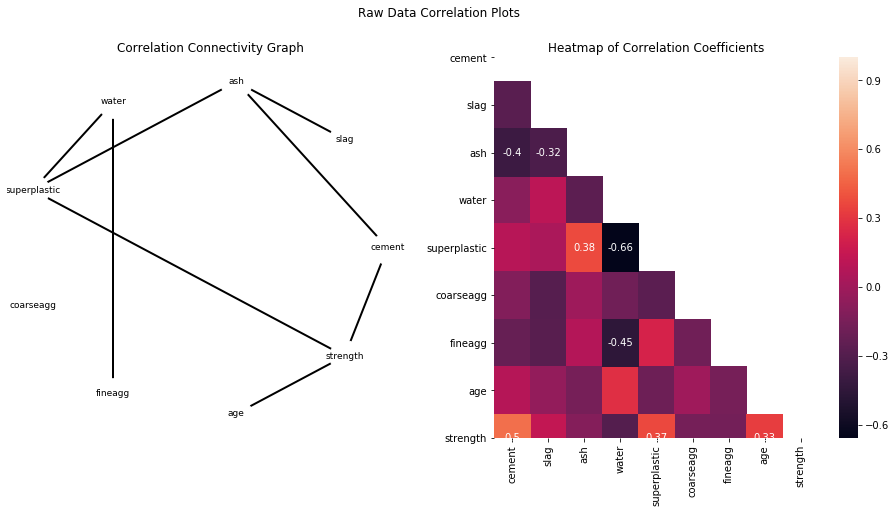

In [14]:
def correlation_plots(df, title, figsize, ul, ll, orient='h'):

    p1 = None
    p2 = None
    if(orient=='h'):
        p1 = 121
        p2 = 122
    else:
        p1 = 211
        p2 = 212 

    plt.figure(figsize=figsize)
    plt.subplot(p1)
    plt.title('Correlation Connectivity Graph')
    options = {
        'node_color': 'white',
        'node_size': 1000,
        'width': 2,
        'font_size': 9,
        'font_color': 'black',
    }
    G = nx.from_pandas_adjacency(df.corr().applymap(lambda x: x if((x > ul or x < ll) and x!=1) else 0))
    nx.draw(G, pos=nx.circular_layout(G), with_labels=True, **options)
    plt.subplot(p2)
    x = df.corr()
    mask = np.zeros_like(x, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(x, mask=mask, cbar=False)
    sns.heatmap(x.applymap(lambda x: x if((x > ul or x < ll)) else np.nan), mask=mask, annot=True)
    plt.title('Heatmap of Correlation Coefficients')
    plt.suptitle(title)
    print( x[target][list(
                    map(
                    lambda x: True if((x > ul or x < ll)) else False,
                    x[target])
                )
            ]
        )
            

correlation_plots(df, title='Raw Data Correlation Plots', figsize=(16, 7), ul=0.3, ll=-0.3)

5 Point Summary: 

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


# Box Plots and Histograms

* Box plots will help us look at the distributions more clearly and distplot will tell us more about the distributions of the data.
* Here we have combined them to give a more clearer picture on what are the outliers

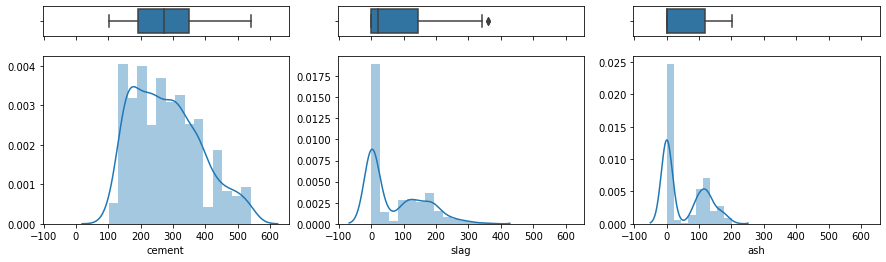

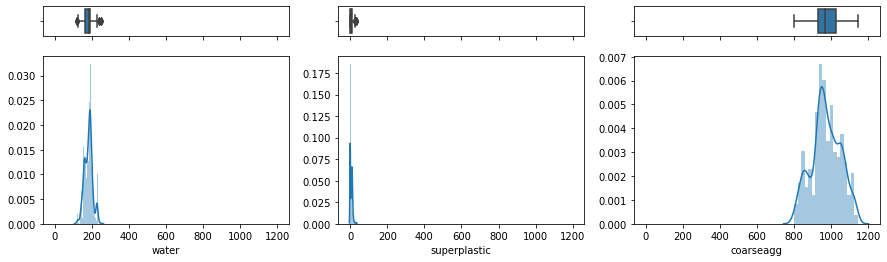

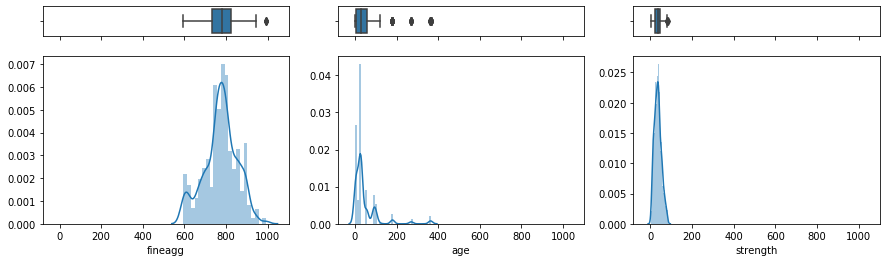

In [16]:

def plot_box_and_hist(df, cols, iy=3, figsize=(15, 4)):
    f, (ax_box, ax_hist) = plt.subplots(2, iy, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    for i in range(0, iy):
        # Add a graph in each part
        sns.boxplot(df[cols[i]], ax=ax_box[i])
        sns.distplot(df[cols[i]], ax=ax_hist[i])

        # Remove x axis name for the boxplot
        ax_box[i].set(xlabel='')
    
    return f

def plot_box_and_hist_all(df):
    cols = df.columns
    if(len(cols) == 9):
        x_plots = int(len(cols)/3)
        y_plots = int(len(cols)/3)
        for x_plot in range(0, x_plots):
            plot_box_and_hist(df, cols[x_plot*3: (x_plot+1)*3])
            plt.show()
            
plot_box_and_hist_all(df)

* From the looks of it there are outliers present in water, superplastic, age, fineagg, slag.
* Most of the features have mix of gaussians because of which there are specific clusters for the strengths. Its better to form clusters while modeling the strengths.
* Except for fineagg and cement everything is skewed in nature.

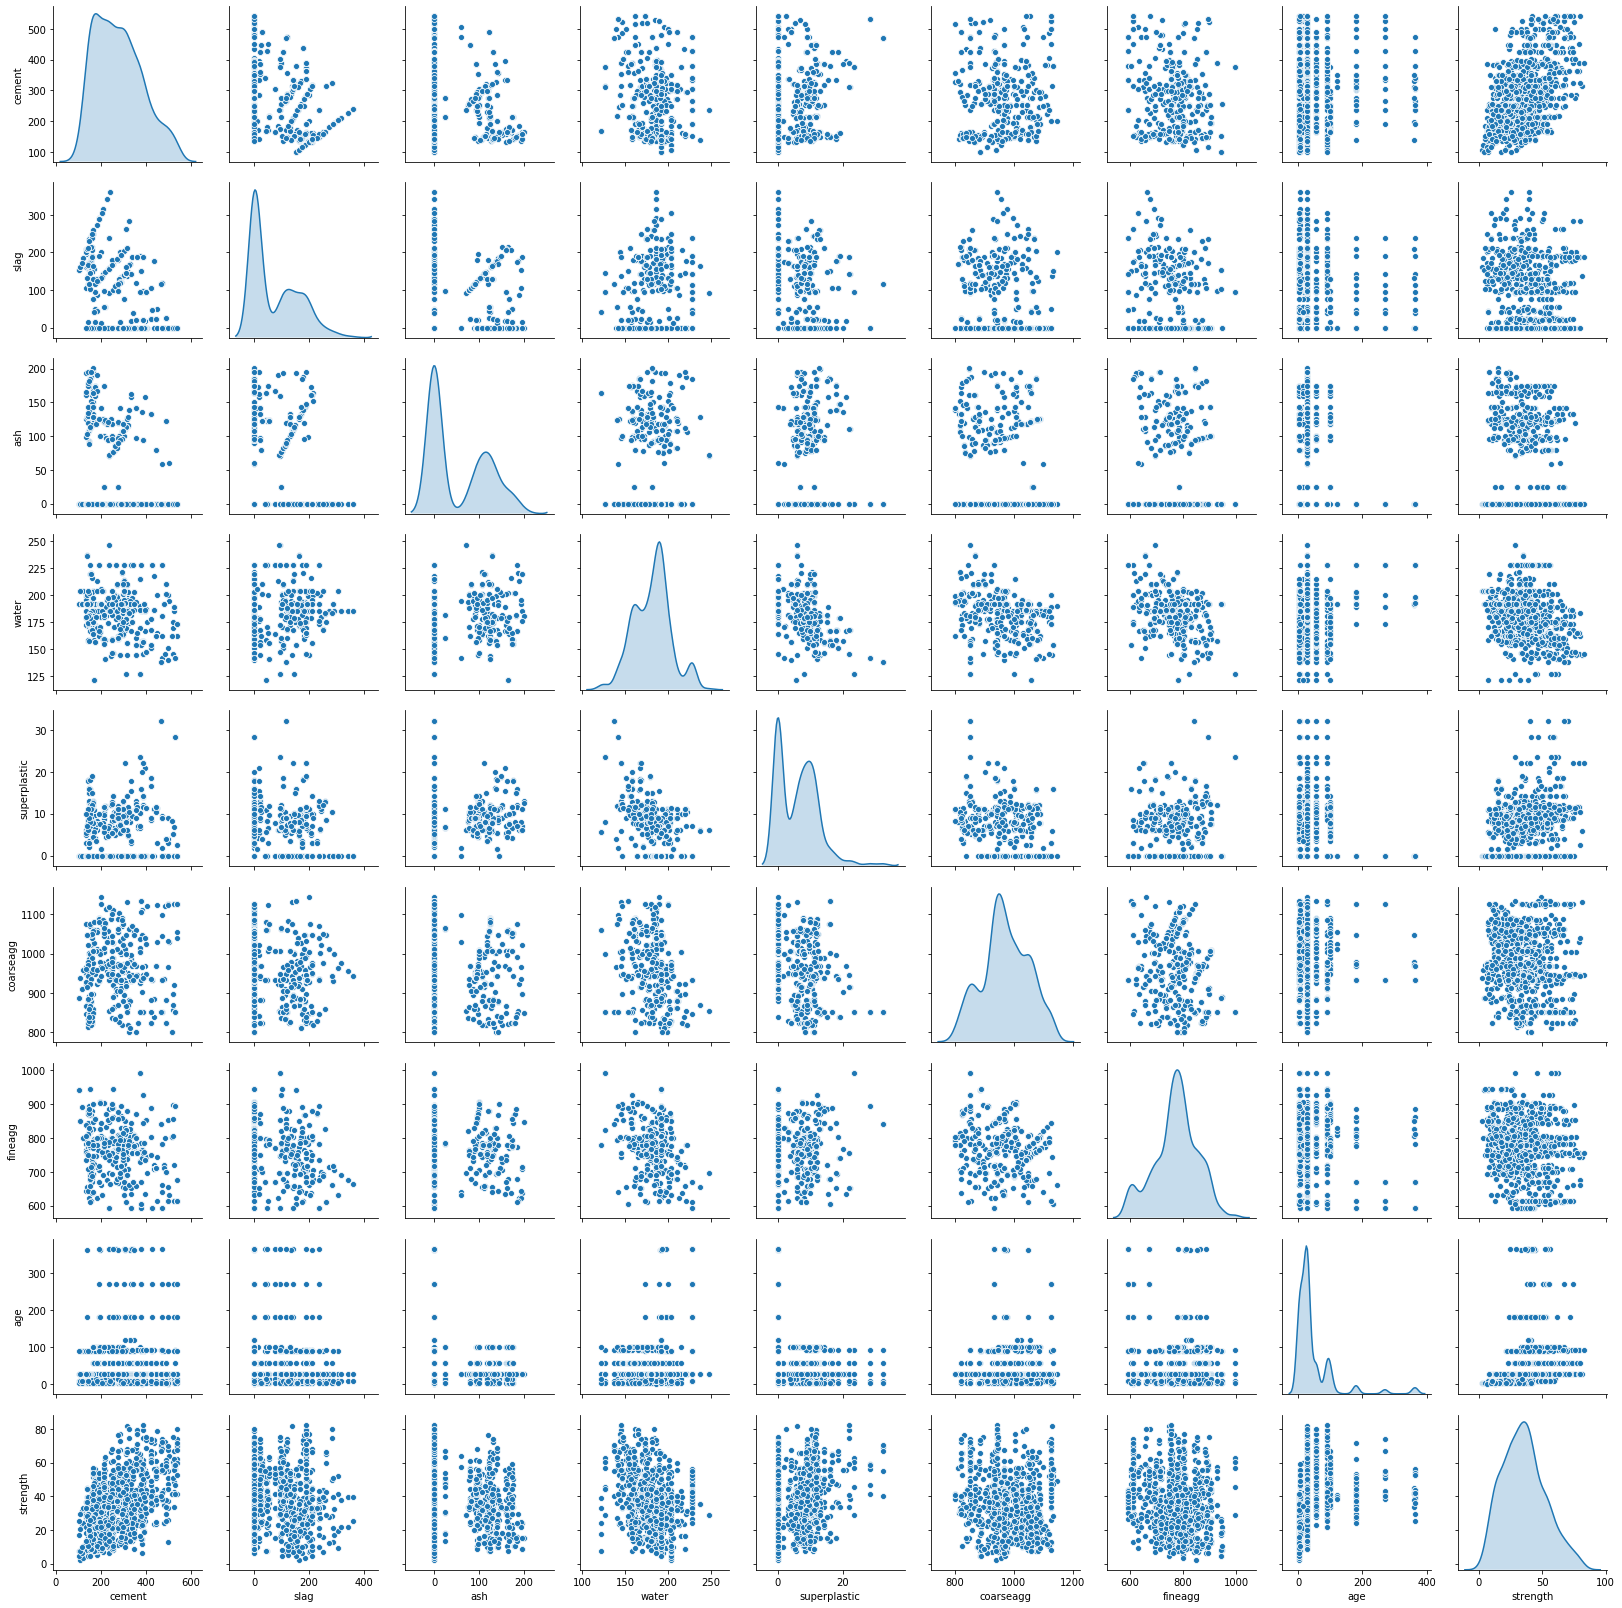

In [18]:
sns.pairplot(df, diag_kind='kde')
plt.show()

* Here its pretty much clear that the features have clusters.
* There are lots of cases of zero due to the different combinations of additives to the concrete.
* When looking at the strength row that there is no proper linear relationship in 2 dimensions. May be generating more features could give us more insights.
* There are clear clusters with ash, superplastic and age. Either we split the models based on the clusters or we use a model which can handle these cases. Decision trees seems like a good option for this kind of data.

# Handling Outliers

Here we will use IQR from box plots and zscores to replace outliers with the mean of the values so that we dont have dataloss.

In [19]:
def IQR_outlier_removal(x):
    Q3 = x.quantile(0.75)
    Q1 = x.quantile(0.25)
    low_lim = Q1 - (Q3 - Q1)
    up_lim =  Q3 + (Q3 - Q1)
    return list( map( lambda x: x if(x < up_lim and x > low_lim) else np.nan, x.values) )
def zscore_outlier_removal(x, dev):
    temp_df = x[x.apply(zscore) < dev]
    temp_df = temp_df[x.apply(zscore) > -dev]
    return temp_df

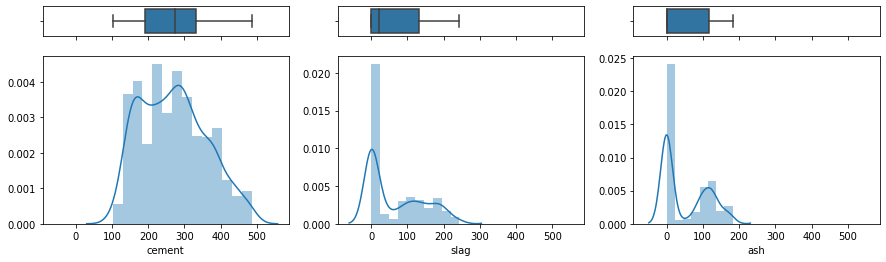

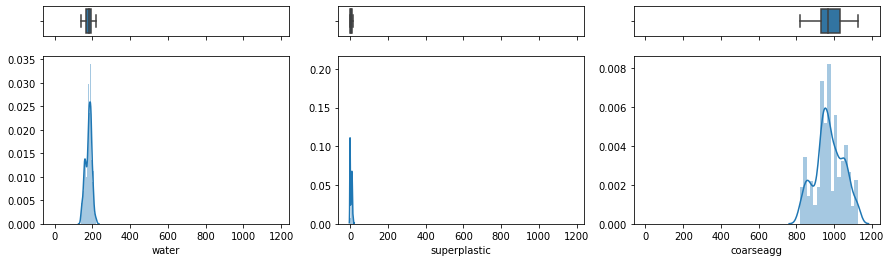

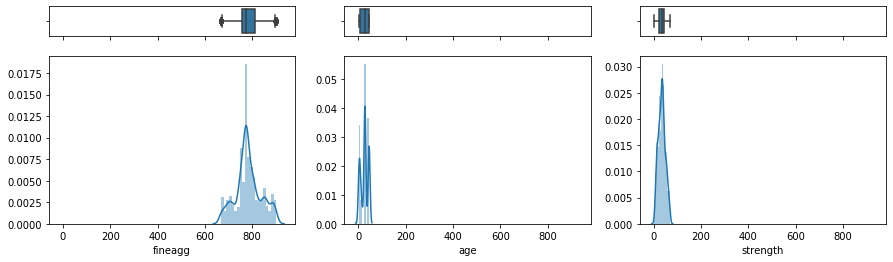

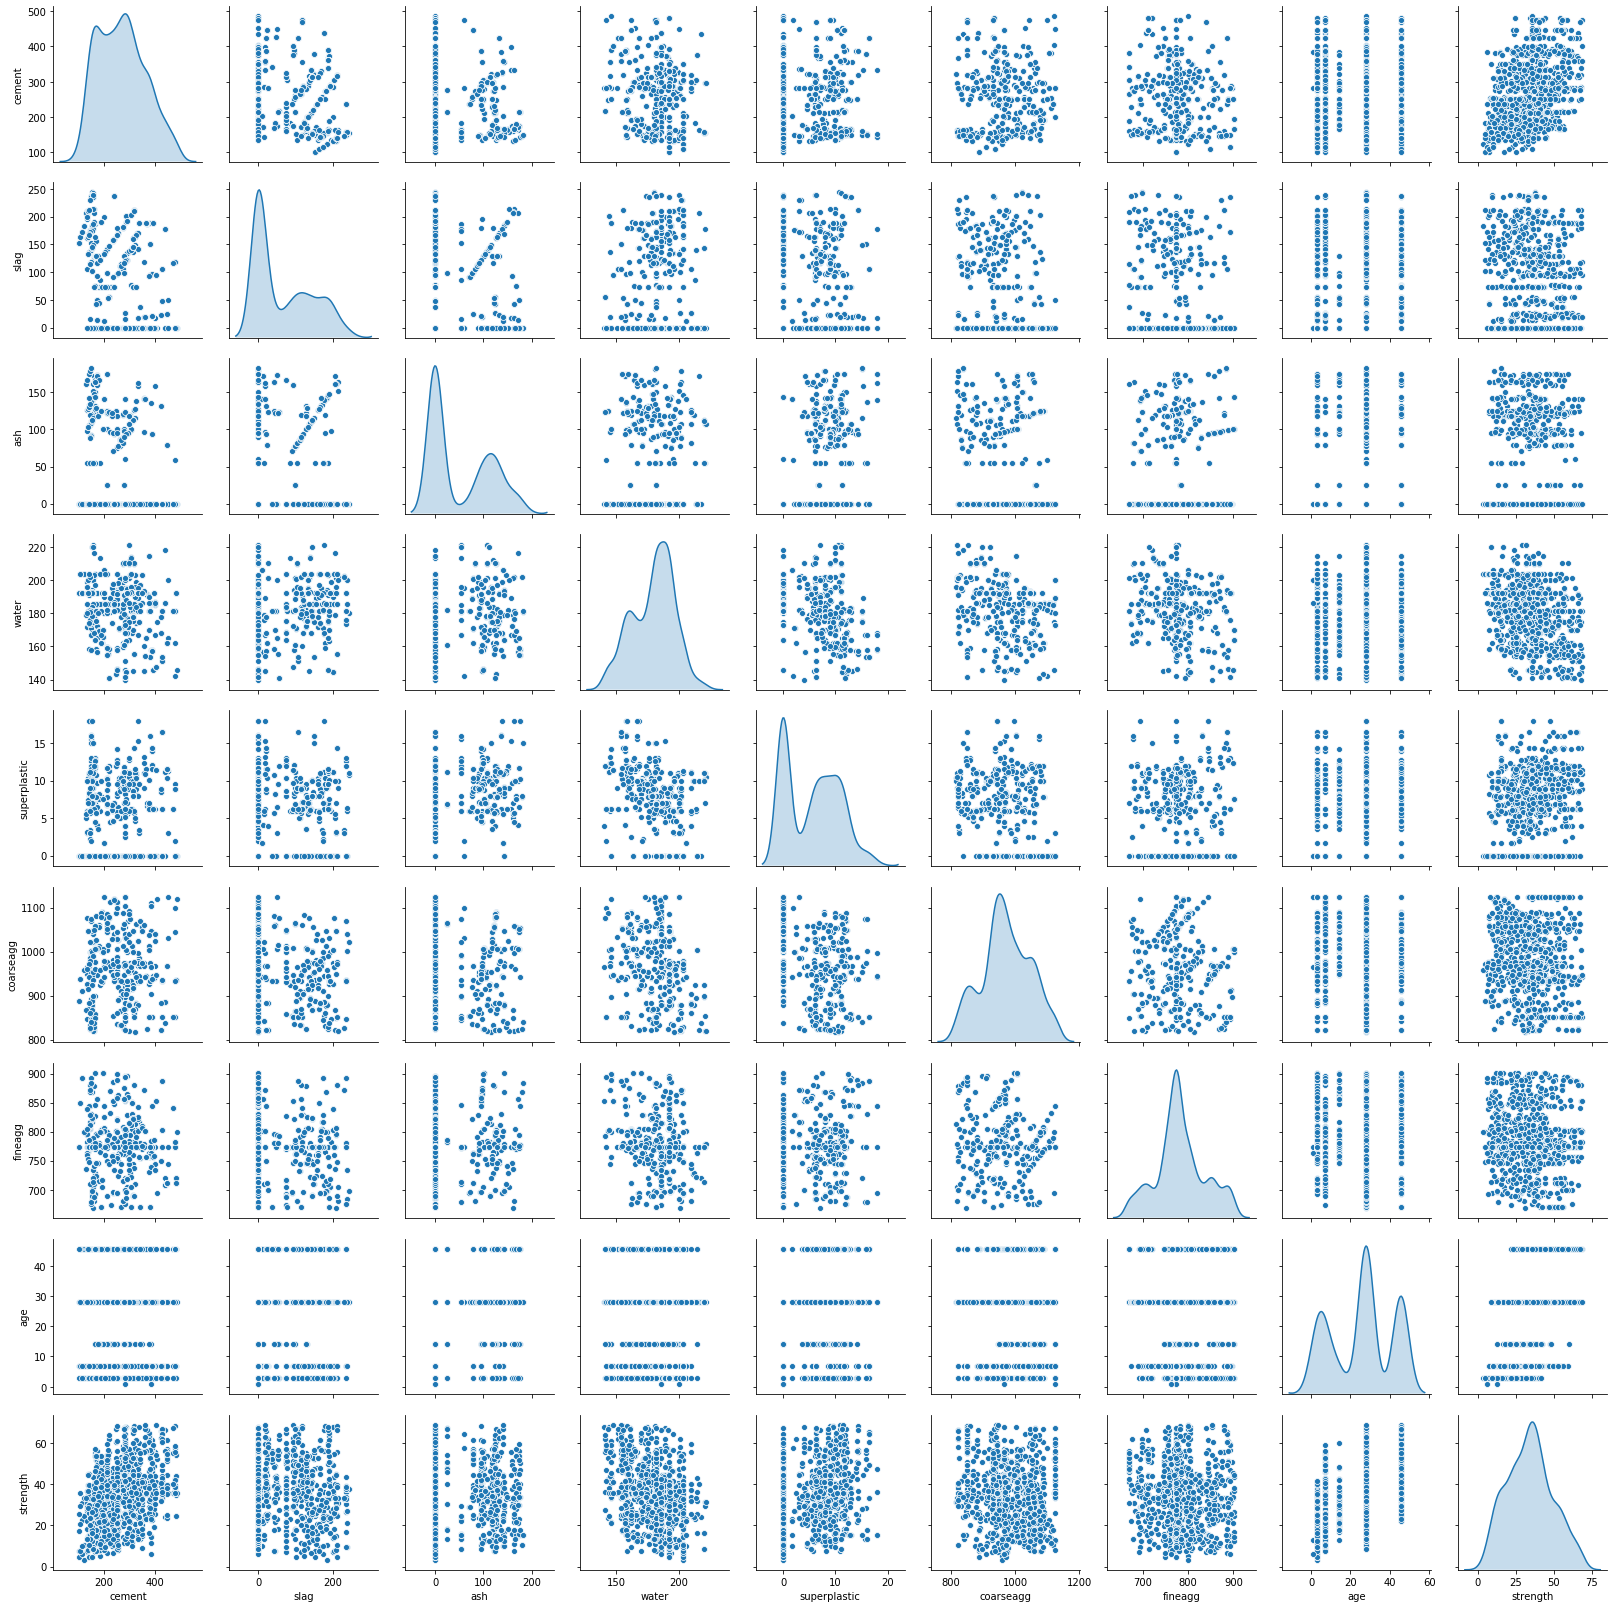

In [20]:

o_df = zscore_outlier_removal(df, 2)
o_df["fineagg"] = IQR_outlier_removal(o_df["fineagg"])
o_df["age"] = IQR_outlier_removal(o_df["age"])
o_df.fillna(df.mean(), inplace=True)
plot_box_and_hist_all(o_df)
sns.pairplot(o_df, diag_kind='kde')
plt.show()

The plots are more clear to some extent but there are no strong functional relations present.

# Feature Generation and Elimination

Here we will use polynomial features and PCA to see if we can get a more promising relation with the strength parameters
also lets check the multicollinearity to see if we can reduce any columns.

In [21]:
poly = PolynomialFeatures(4)
poly_values = poly.fit_transform(o_df.drop(target, axis=1))

def proper_feature_names(df, poly):
    cols = [' + ', '**']
    poly_cols = [' ', '^']
    poly_features = poly.get_feature_names(df.columns)
    # Cleaning the text
    for col, poly_col in zip(cols, poly_cols):
        poly_features = list(map(lambda x: x.replace(poly_col, col), poly_features))
    return poly_features

poly_df = pd.DataFrame(poly_values, columns=proper_feature_names(o_df.drop(target, axis=1), poly))
poly_df[target] = df[target]

In [22]:
x = poly_df.corr()[target]
ul = 0.67
ll = -0.5
fltr = list(map(lambda x: True if(x >= ul or x <= ll) else False, x))
x[fltr].sort_values()

water**2 + coarseagg + fineagg       -0.509013
cement + coarseagg + fineagg + age    0.676665
cement + coarseagg + age              0.686725
cement + fineagg + age                0.686916
cement + age                          0.697483
strength                              1.000000
Name: strength, dtype: float64

In [23]:
cols = list(df.columns)
cols.append("water**2 + coarseagg + fineagg")
cols.append("cement + coarseagg + age")
cols.append("cement + fineagg + age")
cols.append("cement + age")
print(cols)
poly_and_o_df = poly_df[cols]

['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age', 'strength', 'water**2 + coarseagg + fineagg', 'cement + coarseagg + age', 'cement + fineagg + age', 'cement + age']


cement                            0.452896
water                            -0.408168
superplastic                      0.314725
age                               0.586902
strength                          1.000000
water**2 + coarseagg + fineagg   -0.509013
cement + coarseagg + age          0.686725
cement + fineagg + age            0.686916
cement + age                      0.697483
Name: strength, dtype: float64


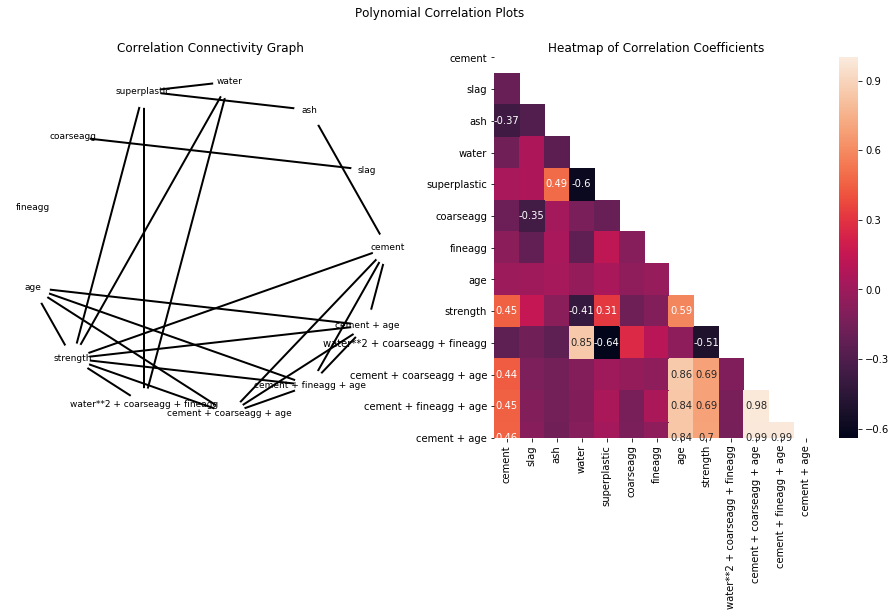

In [24]:

correlation_plots(poly_and_o_df, title='Polynomial Correlation Plots', figsize=(16, 7), ul=0.3, ll=-0.3)

When we compare the classical raw features with strength there is a weak correlation. But when we use composite features we find that the correlation with strength is increased so we will use these composite features for the models instead of removing any correlated columns from the dataset. This leaves us with the following columns:

- slag
- ash
- strength
- superplastic
- strength
- water**2 + coarseagg + fineagg
- cement + fineagg + age
- cement + age

In [25]:
cols = [
    "slag",
    "ash",
    "strength",
    "superplastic",
    "water**2 + coarseagg + fineagg",
    "cement + fineagg + age",
    "cement + age"
]
poly_and_o_df = poly_and_o_df[cols]
poly_and_o_df.head()

,slag,ash,strength,superplastic,water**2 + coarseagg + fineagg,cement + fineagg + age,cement + age
0,212.0,0.0,29.89,0.0,3.012295e+10,2961365.40,3956.4
1,42.2,124.3,23.51,10.8,2.156400e+10,1882694.52,2364.6
2,0.0,95.7,29.22,5.5,2.894075e+10,6028400.00,7000.0
3,114.0,0.0,45.85,0.0,2.058571e+10,4990160.00,7448.0
4,183.4,0.0,18.29,9.1,2.726604e+10,3019776.48,4334.4


We will use PCA here to reduce the complex features and see which composite features capture the complete variance of the data.

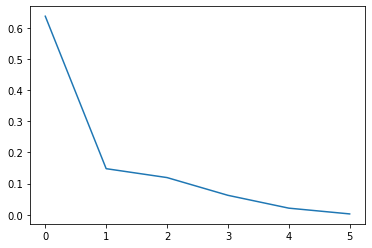

,z0,z1,z2,z3,z4,z5,strength
0,-1.213197e+11,1.902181e+11,-1.732235e+11,1.749069e+11,-1.927723e+10,-1.925356e+09,29.89
1,5.329055e+11,2.490322e+10,-1.906052e+11,-4.074587e+10,6.364986e+10,1.980498e+10,23.51
2,-8.933056e+09,-2.648494e+11,-7.649380e+10,-6.138047e+10,-1.154837e+10,-4.702527e+08,29.22
3,-3.303622e+11,2.910349e+11,2.922462e+10,-1.618166e+10,-6.609624e+10,-4.501404e+09,45.85
4,1.874803e+11,3.465254e+11,-1.264614e+11,1.628067e+11,-1.367265e+10,-4.455801e+09,18.29


In [26]:
pca = PCA(n_components=6)
pca_df = pd.DataFrame(pca.fit_transform(poly_df.drop(target, axis=1)))
pca_df.columns = ["z"+str(i) for i in range(0, len(pca_df.columns))]
plt.plot(pca.explained_variance_ratio_)
plt.show()
pca_df[target] = df[target]
pca_df.head()

So we have now three dataframes to choose for the task:

- Classical training set (df)
- Polynomial features and correlation filtered (poly_and_o_df)
- Polynomials with pca (pca_df)

We will use these for the training purposes.

# Clustering Analysis

After experimenting with the combinations of metrics and methods the cophenetic_correlation was the highest for metric euclidean and method as average. As we can see there are so many cluster levels. But if we take a threshold level of the distance then for 3.6 and more we can form 4 clusters of the data. The dendogram below is the proof for this:

0.681579631304463

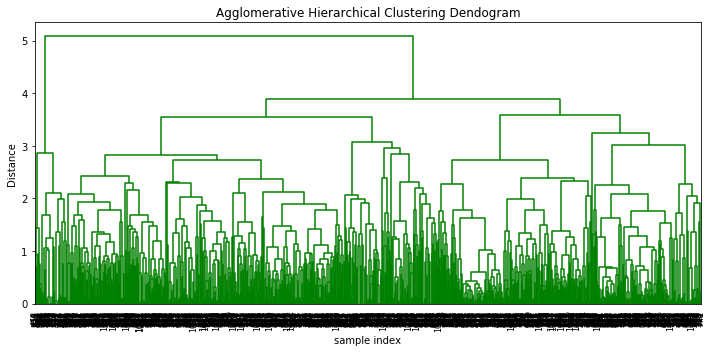

In [27]:
Z = linkage(poly_and_o_df.apply(zscore), metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(poly_and_o_df.apply(zscore)))
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()
c

In [28]:

model = AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='average')
model = model.fit(poly_and_o_df.apply(zscore))
poly_and_o_df['labels'] = model.labels_

poly_and_o_df.groupby('labels').describe()['strength']

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,981.0,34.220734,15.358498,2.33,23.14,33.49,43.94,81.75
1,49.0,67.795102,8.419199,47.97,63.40,66.78,74.36,82.60


From the looks of this we could build a model which follows the label as a selector and then apply a complex model on top of it. The problem with this approach is that we have very less data points for each cluster. There are two clusters - one is for the low grade concreate whose min is 2.33 and other is a concreate whose min strength is 47.97

This means we can use some classical model for those 49 data points and for the other 981 points we could make a strong ML model using Decision Trees and Random Forests lets use labels as a feature for the analysis.



# Data Preparation

In [29]:
target = "strength"

X = poly_and_o_df.drop(target, axis=1)
y = poly_and_o_df[[target]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

We are going to use minmax scaler along with all the models. The models will be:

- Linear Regression (LR)
- Support Vector Regression (SVR)
- Decision Tree
- Bagging
- Random Forest
- Gradient Boosting
- XGBoost
- Light GBM

For hyper parameter tuning we are using GridSearchCV with a K of 5.
we are making use of make_pipeline so that we can wrap the transformation along with the model.

In [30]:
pipelines = {}
pipelines["LR"] = make_pipeline( MinMaxScaler(), (LinearRegression()))
pipelines["SVR"] = make_pipeline(
    MinMaxScaler(), 
    GridSearchCV(
        SVR(),
        param_grid={
            'C': [0.1, 0.5, 1],
            'kernel': ['linear', 'rbf', 'poly'] 
        },
        cv=5,
        refit=True)
   )

pipelines["Decision Tree"] = make_pipeline(
    MinMaxScaler(), 
    GridSearchCV(
        DecisionTreeRegressor(),
        param_grid={
            'max_depth': [2, 4, 6],
            'max_leaf_nodes':[5, 10, 15]
        },
        cv=5,
        refit=True)
   )

pipelines["Bagging"] = make_pipeline(
    MinMaxScaler(),
    GridSearchCV(
        BaggingRegressor(),
        param_grid={
            'n_estimators':[5, 7]
        },
        cv=5,
        refit=True
    )
)

pipelines["Random Forest"] = make_pipeline( 
    MinMaxScaler(), 
    GridSearchCV(
        RandomForestRegressor(),
        param_grid={
           'n_estimators': [40, 50, 60, 70, 80]
        },
        cv=5,
        refit=True
    )
) 

pipelines["Gradient Boosting"] = make_pipeline( 
    MinMaxScaler(), 
    GridSearchCV(
        GradientBoostingRegressor(),
        param_grid={
             'n_estimators': [40, 50, 60, 70, 80]
        },
        cv=5,
        refit=True
    )
) 

pipelines["XGBoost"] = make_pipeline( 
    MinMaxScaler(),
    GridSearchCV(
        XGBRegressor(),
        param_grid={
           'n_estimators': [40, 50, 60, 70, 80]
        },
        cv=5,
        refit=True
    )
)

pipelines["LightGBM"] = make_pipeline( 
    MinMaxScaler(),
    GridSearchCV(
        LGBMRegressor(),
        param_grid={
            'n_estimators': [40, 50, 60, 70, 80]
        },
        cv=5,
        refit=True
    )
)

In [31]:
for keys, values in pipelines.items():
    print("Training: ", keys)
    values.fit(X_train, y_train.values)

Training:  LR
Training:  SVR
Training:  Decision Tree
Training:  Bagging
Training:  Random Forest
Training:  Gradient Boosting
Training:  XGBoost
Training:  LightGBM


In [32]:
_y_train = {}
_y_test = {}
for keys, values in pipelines.items():
    _y_train[keys] = pipelines[keys].predict(X_train)
    _y_test[keys] = pipelines[keys].predict(X_test)

In [33]:
def regression_scoreboard(y_true, y_pred):
    scoreboard = []
    for keys, values in pipelines.items():
        scores = {}
        scores['models'] = keys
        scores["explained_variance_score"] = explained_variance_score(y_true, y_pred[keys])
        scores["mean_absolute_error"] = mean_absolute_error(y_true, y_pred[keys])
        scores["mean_squared_error"] = mean_squared_error(y_true, y_pred[keys])
        scores["r2_score"] = r2_score(y_true, y_pred[keys])
        scoreboard.append(scores)
    scoreboard_df = pd.DataFrame(scoreboard)
    #scoreboard_df.set_index("models", inplace=True)

    return scoreboard_df

def total_scoreboard(y_train, _y_train, y_test, _y_test):
    train_sb = regression_scoreboard(y_train, _y_train)
    test_sb = regression_scoreboard(y_test, _y_test)
    train_sb["dataset"] = "train"
    test_sb["dataset"] = "test"
    sb = pd.concat([train_sb, test_sb])
    sb.set_index(["models", "dataset"], inplace=True)
    return sb.sort_values("models")

total_scoreboard(y_train, _y_train, y_test, _y_test)

explained_variance_score  mean_absolute_error  \
models            dataset                                                  
Bagging           train                    0.963486             2.049927   
                  test                     0.853947             4.614177   
Decision Tree     train                    0.759483             6.321786   
                  test                     0.714232             6.869699   
Gradient Boosting train                    0.903879             3.831731   
                  test                     0.846482             5.018537   
LR                train                    0.681223             7.254788   
                  test                     0.679620             7.173705   
LightGBM          train                    0.967169             2.133842   
                  test                     0.869941             4.357964   
Random Forest     train                    0.975529             1.794609   
                  test                     0.852765             4.428701   
SVR               train                    0.670526             7.300849   
                  test                     0.661098             7.149872   
XGBoost           train                    0.991114             0.805405   
                  test                     0.893357             3.814094   

                           mean_squared_error  r2_score  
models            dataset                                
Bagging           train             10.113554  0.963484  
                  test              41.797409  0.853926  
Decision Tree     train             66.614886  0.759483  
                  test              81.807266  0.714099  
Gradient Boosting train             26.622271  0.903879  
                  test              43.963188  0.846357  
LR                train             88.290226  0.681223  
                  test              91.673398  0.679619  
LightGBM          train              9.092918  0.967169  
                  test              37.219457  0.869925  
Random Forest     train              6.780848  0.975517  
                  test              42.134250  0.852749  
SVR               train             92.014468  0.667776  
                  test              97.683165  0.658616  
XGBoost           train              2.461246  0.991114  
                  test              30.533407  0.893291

18.439115429993805


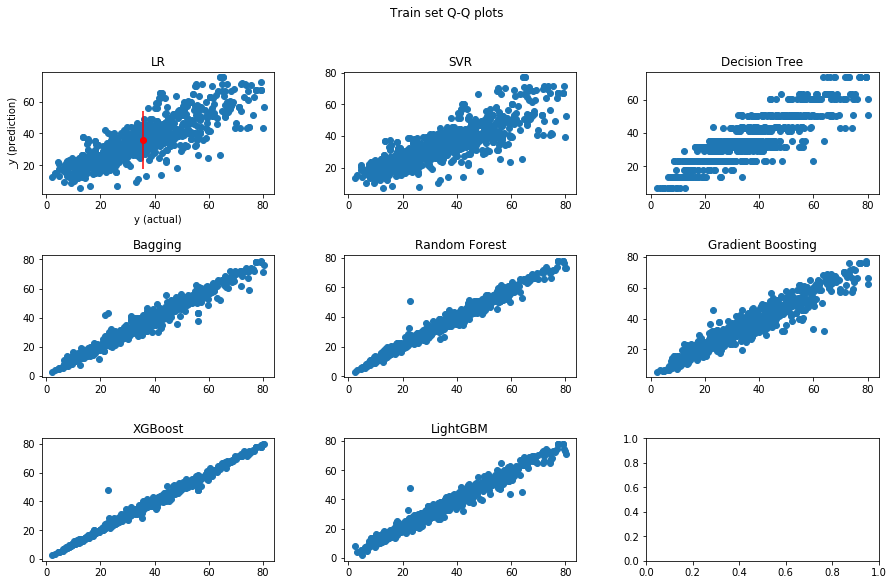

In [34]:
cols = list(pipelines.keys())

from numpy import sum as arraysum
from math import sqrt

def stddev(y, yhat):
    sum_errs = arraysum((y - yhat)**2)
    stdev = sqrt(1/(len(y)-2) * sum_errs)
    return stdev

def QQPlot(y, _y, cols, title):
    fig, ax = plt.subplots(3, 3, figsize=(15, 9))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    for i in range(0, 3):
        for j in range(0, 3):
            try:
                plt.sca(ax[i,j])
                plt.scatter(y, _y[cols[i*3+j]])
                plt.title(cols[i*3+j])
                interval = 1.96 * stddev(y, _y[cols[i*3+j]])
                plt.errorbar(y.mean(), _y[cols[i*3+j]].mean(), yerr=interval, color='red', fmt='o')
                print(interval)
                plt.xlabel("y (actual)")
                plt.ylabel("_y (prediction)")
            except Exception:
                continue
    fig.suptitle(title)

QQPlot(y_train, _y_train, cols, title="Train set Q-Q plots")

18.858027371768458


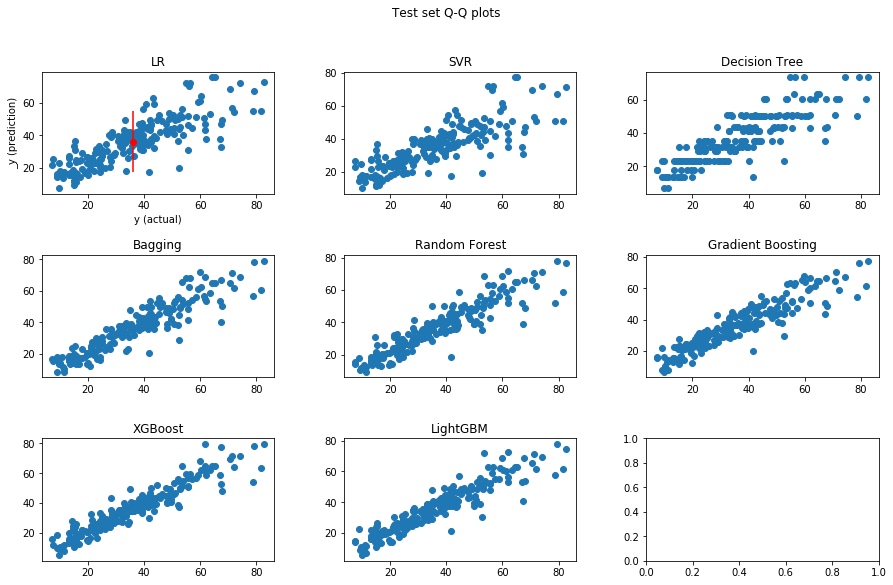

In [35]:
QQPlot(y_test, _y_test, cols, title="Test set Q-Q plots")

- Looking at the Q-Q plots its clear how the predicitions and actual value distributions are matching the most in all ensemble models.

- Bagging, XGBoost, LightGBM and Gradient Boosting are looking very good in terms of test set Q-Q plots.

- Comparing the score board the best final candidates are Gradient Boosting and XGBoost and both of them are comparable in performance.

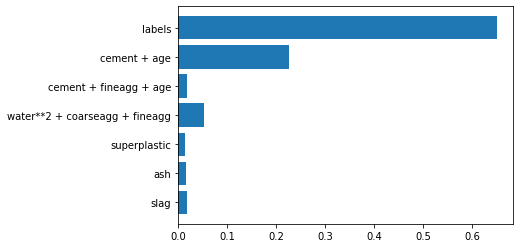

In [36]:
model = pipelines["XGBoost"][1].best_estimator_
plt.barh(range(len(model.feature_importances_)), model.feature_importances_)
plt.yticks([0, 1, 2, 3, 4, 5, 6], list(poly_and_o_df.drop(target, axis=1).columns))
plt.show()

* From this we know that cement + age and water**2 + coarseagg + fineagg are important factors for the model to effectivly make stronger cement.
* Labels is the grade of the cement strength which we have made from agglomeritive clustering.
* There is a theory that the water to cement ratio determines the strength of the cement.

# Hypothesis Testing

Lets do some hypothesis testing on the models so we can confidently say the models are properly modeling the distributions.

In [37]:
def hypothesis_testing(y, _y, conf, target, name):
    group1 = y.values
    group2 = _y.reshape(-1, 1)

    #sns.distplot(group1, label=target)
    #sns.distplot(group2, label=name)
    #plt.legend()
    #plt.show()

    shapiro_statistic, p_value = shapiro(group1)
    gs1 = [ name, "shapiro", "group1", round(shapiro_statistic, 2), round(p_value, 2) ]

    if(p_value > conf):
        gs1.append("accept")
    else:
        gs1.append("reject")

    shapiro_statistic, p_value = shapiro(group2)
    gs2 = [name ,"shapiro", "group2", round(shapiro_statistic, 2), round(p_value, 2)]

    if(p_value > conf):
        gs2.append("accept")
    else:
        gs2.append("reject")


    t_statistic, p_value = ttest_ind(group1, group2)
    gs3 = [name, "t-test", "group1 and group2", round(t_statistic[0], 2), round(p_value[0], 2)]

    if(p_value > conf):
        gs3.append("accept")
    else:
        gs3.append("reject")

    t_statistic, p_value = mannwhitneyu(group1, group2)
    gs4 = [name, "mann whitney u test", "group1 and group2", round(t_statistic, 2), round(p_value, 2)]

    if(p_value > conf):
        gs4.append("accept")
    else:
        gs4.append("reject")

    test = pd.DataFrame([gs1, gs2, gs3, gs4], columns=["model", "test name", "distributions", "statistic", "p_value", "H0"])
    #test.set_index("test name", inplace=True)
    return test

def hypothesis_test_all(y_train, _y_train, y_test, _y_test):
    scoreboard = pd.DataFrame()
    for key, values in pipelines.items():
        df1 = hypothesis_testing(y_train, _y_train[key], conf=0.05,target=target, name=target + " ({})".format(key))
        df1["model"] = key
        df1["dataset"] = "train"
        df2 = hypothesis_testing(y_test, _y_test[key], conf=0.05,target=target, name=target + " ({})".format(key))
        df2["model"] = key
        df2["dataset"] = "test"
        scoreboard = pd.concat([scoreboard, df1, df2], axis=0)
    return scoreboard.set_index(["model",  "dataset", "test name"])

In [38]:
hypothesis_test_all(y_train, _y_train, y_test, _y_test)

distributions  statistic  \
model             dataset test name                                           
LR                train   shapiro                         group1       0.98   
                          shapiro                         group2       0.97   
                          t-test               group1 and group2      -0.00   
                          mann whitney u test  group1 and group2  336153.00   
                  test    shapiro                         group1       0.97   
                          shapiro                         group2       0.98   
                          t-test               group1 and group2       0.01   
                          mann whitney u test  group1 and group2   20807.00   
SVR               train   shapiro                         group1       0.98   
                          shapiro                         group2       0.96   
                          t-test               group1 and group2       1.19   
                          mann whitney u test  group1 and group2  332169.00   
                  test    shapiro                         group1       0.97   
                          shapiro                         group2       0.96   
                          t-test               group1 and group2       0.56   
                          mann whitney u test  group1 and group2   21006.00   
Decision Tree     train   shapiro                         group1       0.98   
                          shapiro                         group2       0.97   
                          t-test               group1 and group2       0.00   
                          mann whitney u test  group1 and group2  338242.00   
                  test    shapiro                         group1       0.97   
                          shapiro                         group2       0.96   
                          t-test               group1 and group2      -0.12   
                          mann whitney u test  group1 and group2   20849.00   
Bagging           train   shapiro                         group1       0.98   
                          shapiro                         group2       0.98   
                          t-test               group1 and group2      -0.02   
                          mann whitney u test  group1 and group2  338003.00   
                  test    shapiro                         group1       0.97   
                          shapiro                         group2       0.97   
                          t-test               group1 and group2      -0.05   
                          mann whitney u test  group1 and group2   20977.00   
Random Forest     train   shapiro                         group1       0.98   
                          shapiro                         group2       0.98   
                          t-test               group1 and group2      -0.07   
                          mann whitney u test  group1 and group2  337460.00   
                  test    shapiro                         group1       0.97   
                          shapiro                         group2       0.97   
                          t-test               group1 and group2      -0.04   
                          mann whitney u test  group1 and group2   20911.00   
Gradient Boosting train   shapiro                         group1       0.98   
                          shapiro                         group2       0.98   
                          t-test               group1 and group2       0.00   
                          mann whitney u test  group1 and group2  336923.00   
                  test    shapiro                         group1       0.97   
                          shapiro                         group2       0.98   
                          t-test               group1 and group2      -0.12   
                          mann whitney u test  group1 and group2   20729.00   
XGBoost           train   shapiro                         group1       0.98   
                      

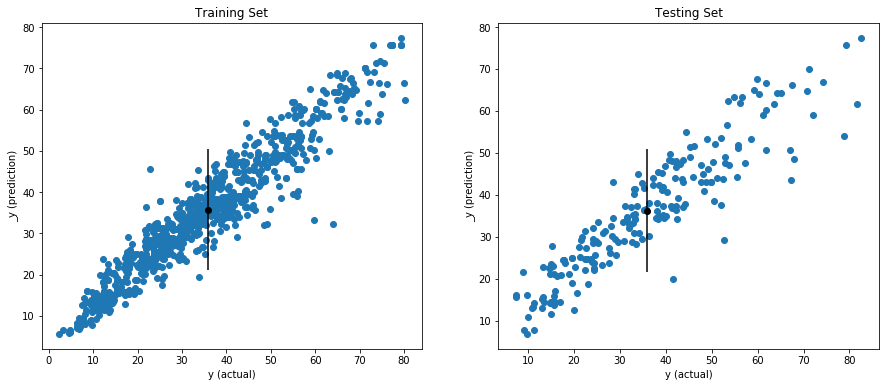

In [39]:
model = "Gradient Boosting"
train_interval = 1.96 * _y_train[model].std()/2
test_interval = 1.96 * _y_test[model].std()/2

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.scatter(y_train, _y_train[model])
plt.errorbar(y_train.mean(), _y_train[model].mean(), yerr=train_interval, color='black', fmt='o')
plt.title("Training Set")
plt.xlabel("y (actual)")
plt.ylabel("_y (prediction)")
plt.subplot(122)
plt.scatter(y_test, _y_test[model])
plt.errorbar(y_test.mean(), _y_test[model].mean(), yerr=test_interval, color='black', fmt='o')
plt.title("Testing Set")
plt.xlabel("y (actual)")
plt.ylabel("_y (prediction)")
plt.show()

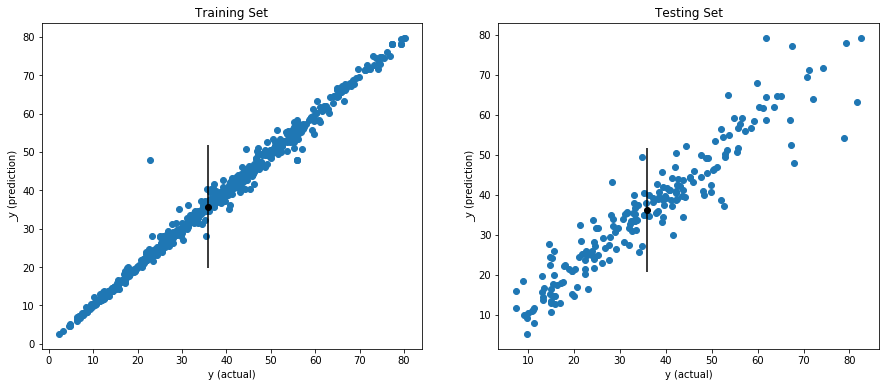

In [40]:
model = "XGBoost"
train_interval = 1.96 * _y_train[model].std()/2
test_interval = 1.96 * _y_test[model].std()/2

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.scatter(y_train, _y_train[model])
plt.errorbar(y_train.mean(), _y_train[model].mean(), yerr=train_interval, color='black', fmt='o')
plt.title("Training Set")
plt.xlabel("y (actual)")
plt.ylabel("_y (prediction)")
plt.subplot(122)
plt.scatter(y_test, _y_test[model])
plt.errorbar(y_test.mean(), _y_test[model].mean(), yerr=test_interval, color='black', fmt='o')
plt.title("Testing Set")
plt.xlabel("y (actual)")
plt.ylabel("_y (prediction)")
plt.show()

* Even at a confidence interval of 95% the predicitions are modeling the actual values properly.